In [1]:
# Hi Giulia
# Question 1-2 must only do fro 2008-2021!!
# Question 1; annualized returns: not done for all the years if we do *12

In [2]:
'''pip install pandas
pip install matplotlib
pip install numpy'''

'pip install pandas\npip install matplotlib\npip install numpy'

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create monthly dataset

In [4]:
#Monthly_reurn include 278 months and 2051 firms (rows)
monthly_RI_index_path = r'C:\Users\giuli\Documents\SEF_Homework1\SEF\ESG_Scores\DS_RI_T_USD_M.xlsx'  # Replace with your Excel file name
df_monthly_RI = pd.read_excel(monthly_RI_index_path)



#Monthly_capitalization include 278 months and 2051 firms 
monthly_capitalization_path = r'C:\Users\giuli\Documents\SEF_Homework1\SEF\ESG_Scores\DS_MV_USD_M.xlsx'  # Replace with your Excel file name
df_monthly_capitalization = pd.read_excel(monthly_capitalization_path)



#M country to region data
region_path = r'C:\Users\giuli\Documents\SEF_Homework1\SEF\CountriesToRegions.xlsx'  # Replace with your Excel file name
df_region = pd.read_excel(region_path)
df_region

,% AMER: Cnada + USA,Unnamed: 1,Unnamed: 2
0,% FRON: Frontier countries,NaN,NaN
1,% SA: Standalone countries,NaN,NaN
2,% EM: Emerging markets,NaN,NaN
3,NaN,NaN,NaN
4,Code,Name,Region
...,...,...,...
97,US,UNITED STATES,AMER
98,VI,"VIRGIN ISLANDS, BRITISH",Other
99,VN,VIET NAM,FRON
100,ZA,SOUTH AFRICA,EM


In [5]:
#Let's keep only the EUR contries

df_region.drop(index=[0,1,2,3], inplace= True )

df_EUR = df_region[df_region['Unnamed: 2'] == 'EUR']

In [6]:
#Rename the column so we can merge later
df_EUR = df_EUR.rename(columns={'% AMER: Cnada + USA' : 'ISIN_First2'})

print(df_EUR)

   ISIN_First2       Unnamed: 1 Unnamed: 2
7           AT          AUSTRIA        EUR
11          BE          BELGIUM        EUR
19          CH      SWITZERLAND        EUR
26          DE          GERMANY        EUR
27          DK          DENMARK        EUR
30          ES            SPAIN        EUR
31          FI          FINLAND        EUR
32          FR          FRANCE         EUR
33          GB  UNITED KINGDOM         EUR
43          IE          IRELAND        EUR
44          IL          ISRAEL         EUR
48          IT            ITALY        EUR
71          NL      NETHERLANDS        EUR
72          NO          NORWAY         EUR
80          PT        PORTUGAL         EUR
87          SE          SWEDEN         EUR


In [7]:
#Now merged with the two dataset 
#First step we need to create a new column with only the 2 first caracters of the columns ISIN

#First with the RI data 

df_monthly_RI['ISIN_First2'] = df_monthly_RI ['ISIN'].str[:2]
print(df_monthly_RI)

              ISIN                                NAME  2000-01-31 00:00:00  \
0     AN8068571086                        SCHLUMBERGER              1858.26   
1     ARALUA010258                               ALUAR              1820.11   
2     ARP125991090                  BBVA BANCO FRANCES               396.54   
3     ARSIDE010029  TERNIUM ARGENTINA SOCIEDAD ANONIMA               177.53   
4     AT00000VIE62                      FLUGHAFEN WIEN               156.25   
...            ...                                 ...                  ...   
2046  ZAE000191342                    ALTRON LIMITED A                43.29   
2047  ZAE000255915                          ABSA GROUP                58.08   
2048  ZAE000298253              NORTHAM PLATINUM HLDGS                 4.13   
2049  ZAE000302618                               AVENG                21.22   
2050  ZAE000322095                              NAMPAK               120.95   

      2000-02-29 00:00:00  2000-03-31 00:00:00  200

In [8]:
#With the capitlization now
df_monthly_capitalization['ISIN_First2'] = df_monthly_capitalization ['ISIN'].str[:2]
print(df_monthly_capitalization )

              ISIN                                NAME  2000-01-31 00:00:00  \
0     AN8068571086                        SCHLUMBERGER             33574.85   
1     ARALUA010258                               ALUAR              1328.64   
2     ARP125991090                  BBVA BANCO FRANCES              1570.39   
3     ARSIDE010029  TERNIUM ARGENTINA SOCIEDAD ANONIMA              1407.47   
4     AT00000VIE62                      FLUGHAFEN WIEN               567.85   
...            ...                                 ...                  ...   
2046  ZAE000191342                    ALTRON LIMITED A               115.91   
2047  ZAE000255915                          ABSA GROUP              2649.35   
2048  ZAE000298253              NORTHAM PLATINUM HLDGS               259.71   
2049  ZAE000302618                               AVENG               445.83   
2050  ZAE000322095                              NAMPAK              1350.98   

      2000-02-29 00:00:00  2000-03-31 00:00:00  200

In [9]:
#Second step we merge the data set with the region, keeping only the one matching the EUR countries
df_EUR_monthly_capitalization = pd.merge(df_EUR,  df_monthly_capitalization, on='ISIN_First2', how='inner')
df_EUR_monthly_RI = pd.merge(df_EUR,  df_monthly_RI, on='ISIN_First2', how='inner')


In [10]:
print(df_EUR_monthly_capitalization)


    ISIN_First2 Unnamed: 1 Unnamed: 2          ISIN                      NAME  \
0            AT    AUSTRIA        EUR  AT00000VIE62            FLUGHAFEN WIEN   
1            AT    AUSTRIA        EUR  AT0000652011          ERSTE GROUP BANK   
2            AT    AUSTRIA        EUR  AT0000743059                       OMV   
3            AT    AUSTRIA        EUR  AT0000746409                   VERBUND   
4            AT    AUSTRIA        EUR  AT0000831706              WIENERBERGER   
..          ...        ...        ...           ...                       ...   
503          SE    SWEDEN         EUR  SE0015988019           NIBE INDUSTRIER   
504          SE    SWEDEN         EUR  SE0016589188              ELECTROLUX B   
505          SE    SWEDEN         EUR  SE0017486889             ATLAS COPCO A   
506          SE    SWEDEN         EUR  SE0018012494  MODERN TIMES GROUP MTG B   
507          SE    SWEDEN         EUR  SE0020050417           BOLIDEN ORD SHS   

     2000-01-31 00:00:00  2

In [11]:
print(df_EUR_monthly_RI)

    ISIN_First2 Unnamed: 1 Unnamed: 2          ISIN                      NAME  \
0            AT    AUSTRIA        EUR  AT00000VIE62            FLUGHAFEN WIEN   
1            AT    AUSTRIA        EUR  AT0000652011          ERSTE GROUP BANK   
2            AT    AUSTRIA        EUR  AT0000743059                       OMV   
3            AT    AUSTRIA        EUR  AT0000746409                   VERBUND   
4            AT    AUSTRIA        EUR  AT0000831706              WIENERBERGER   
..          ...        ...        ...           ...                       ...   
503          SE    SWEDEN         EUR  SE0015988019           NIBE INDUSTRIER   
504          SE    SWEDEN         EUR  SE0016589188              ELECTROLUX B   
505          SE    SWEDEN         EUR  SE0017486889             ATLAS COPCO A   
506          SE    SWEDEN         EUR  SE0018012494  MODERN TIMES GROUP MTG B   
507          SE    SWEDEN         EUR  SE0020050417           BOLIDEN ORD SHS   

     2000-01-31 00:00:00  2

In [12]:
df_EUR_monthly_capitalization.to_csv('/Users/giuli\Documents\SEF_Homework1\SEF/df_EUR_monthly_capitalization.csv', index=False)
df_EUR_monthly_RI.to_csv('/Users/giuli\Documents\SEF_Homework1\SEF/df_EUR_monthly_RI.csv', index=False)
#We have now 508 firms with the data for 281 months (minus the first columns)

# Import monthly dataset

In [5]:
url = "https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_monthly_capitalization.csv"
df_capitalization_monthly = pd.read_csv(url)
#df_capitalization_monthly

In [6]:
url0 = "https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_monthly_return.csv"
df_RI_monthly = pd.read_csv(url0)
#df_RI_monthly

# Import yearly dataset

In [7]:
url1 = "https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_yearly_capitalization.csv"
df_capitalization_yearly = pd.read_csv(url1)
df_capitalization_yearly

,ISIN_First2,Unnamed: 1,Unnamed: 2,ISIN,NAME,x1999,x2000,x2001,x2002,x2003,...,x2013,x2014,x2015,x2016,x2017,x2018,x2019,x2020,x2021,x2022
0,AT,AUSTRIA,EUR,AT00000VIE62,FLUGHAFEN WIEN,537.09,794.55,560.96,705.15,985.36,...,1765.22,1952.09,1998.43,2073.22,3394.09,3312.76,3559.53,3129.62,2540.95,2900.21
1,AT,AUSTRIA,EUR,AT0000652011,ERSTE GROUP BANK,1956.67,2269.47,2677.13,4006.48,7354.92,...,15002.04,10003.77,13498.31,12613.95,18633.43,14272.63,16191.42,13115.57,20210.51,13715.54
2,AT,AUSTRIA,EUR,AT0000743059,OMV,2611.95,2091.29,2262.75,2651.31,4021.35,...,15689.64,8716.35,9289.96,11584.60,20761.05,14309.77,18398.00,13214.41,18590.05,16800.81
3,AT,AUSTRIA,EUR,AT0000746409,VERBUND,2111.95,1531.28,1129.55,1285.83,1763.91,...,3639.54,3150.65,2193.28,2724.73,4117.86,7246.80,8549.44,14549.09,19145.95,14289.58
4,AT,AUSTRIA,EUR,AT0000831706,WIENERBERGER,1503.25,1247.43,974.04,1161.06,1743.94,...,1866.50,1627.64,2198.92,2044.74,2846.44,2418.25,3450.66,3675.69,4236.26,2690.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,SE,SWEDEN,EUR,SE0015988019,NIBE INDUSTRIER,69.83,71.58,90.24,144.28,352.77,...,2194.30,2494.33,3279.90,3516.13,4276.66,4568.47,7728.50,14629.60,26929.68,16615.26
504,SE,SWEDEN,EUR,SE0016589188,ELECTROLUX B,8916.24,4623.97,5313.72,5345.01,6896.85,...,7889.76,8789.54,7319.69,7491.19,9707.79,6346.39,7385.66,7006.83,7290.80,3714.02
505,SE,SWEDEN,EUR,SE0017486889,ATLAS COPCO A,4118.51,3061.74,3127.48,2729.47,5006.63,...,23302.76,23418.30,20749.39,25640.24,36313.20,19929.54,33500.41,43039.88,58018.90,39667.59
506,SE,SWEDEN,EUR,SE0018012494,MODERN TIMES GROUP MTG B,2201.82,1214.58,1119.36,411.27,1070.25,...,3204.26,1963.34,1587.85,1835.97,2601.53,2195.77,800.33,1198.62,1124.10,1087.43


In [8]:
url2 = "https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_yearly_RI.csv"
df_RIs_yearly = pd.read_csv(url1)
#df_RI_yearly

# Question 1

Compute the annualized average RI and annualized volatility for all individual assets over the period 2008–2022. Plot and comment the histogram of these distributions. Compute and comment on the correlation between individual average RIs and volatilities in the cross section. (10 points)

In [9]:
df_capitalization_monthly.drop(df_capitalization_monthly.columns[:4], axis=1, inplace=True)

In [10]:
df_capitalization_monthly.set_index('NAME', inplace = True)
df_capitalization_monthly_T = df_capitalization_monthly.T
                              

In [11]:
df_capitalization_monthly_T

NAME,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,VOESTALPINE,MAYR-MELNHOF KARTON,IMMOFINANZ,SOLVAY,...,FABEGE,KINNEVIK B,INVESTOR A,SWEDISH MATCH DEAD - DELIST.02/01/23,HEXAGON B,NIBE INDUSTRIER,ELECTROLUX B,ATLAS COPCO A,MODERN TIMES GROUP MTG B,BOLIDEN ORD SHS
2000-01-31 00:00:00,567.85,1803.98,2583.84,1655.07,1386.43,147.82,1065.59,644.41,263.96,5767.75,...,350.51,435.17,5449.81,1443.42,197.04,61.11,7593.79,3539.84,2083.35,231.99
2000-02-29 00:00:00,559.05,1857.91,2113.74,1781.21,1283.95,142.98,1016.74,659.49,261.40,5861.75,...,365.35,548.46,5599.56,1398.86,212.77,64.39,6702.68,3231.37,2318.42,176.27
2000-03-31 00:00:00,576.48,1910.40,2065.10,1618.73,1428.44,142.12,1026.40,604.19,260.94,6044.04,...,384.71,579.72,6065.19,1320.16,232.88,68.47,6739.48,3400.32,2166.79,277.91
2000-04-30 00:00:00,498.86,1827.24,2223.10,1446.45,1487.43,139.02,944.30,567.35,318.10,5709.31,...,398.26,499.03,5657.33,1194.48,218.50,67.18,6026.53,3273.63,2195.59,219.57
2000-05-31 00:00:00,517.64,1810.26,2305.32,1554.72,1567.26,145.87,912.06,567.61,333.43,5630.25,...,382.20,472.14,5317.04,1239.84,209.29,65.64,6006.13,3104.37,1990.56,231.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 00:00:00,2778.87,9715.28,13255.37,16321.45,2703.34,3043.93,3612.25,2996.46,2063.65,8585.01,...,2940.99,3479.40,20847.37,15360.14,26713.27,16809.54,3496.16,34336.09,1119.39,8836.91
2022-09-30 00:00:00,2719.75,9532.79,11981.47,14584.20,2324.62,2620.80,3062.82,2586.32,1695.41,8260.50,...,2262.35,3227.76,19272.98,15116.01,24484.81,16082.16,2878.77,31707.46,846.93,8541.12
2022-10-31 00:00:00,2739.62,10602.50,15085.69,13333.42,2634.32,2865.33,3878.67,2846.36,1636.38,9547.28,...,2400.10,2997.73,21199.72,15677.18,25645.89,14214.49,3389.53,35865.30,951.81,7959.95
2022-11-30 00:00:00,2854.20,13099.32,16902.76,15082.96,2896.84,2939.04,4772.57,3336.07,1753.36,10234.37,...,2699.29,3626.43,23377.18,16445.79,28753.87,16381.75,3828.45,40666.87,978.44,9949.04


In [12]:
df_returns_monthly = df_capitalization_monthly_T.pct_change()

In [13]:
df_returns_monthly

NAME,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,VOESTALPINE,MAYR-MELNHOF KARTON,IMMOFINANZ,SOLVAY,...,FABEGE,KINNEVIK B,INVESTOR A,SWEDISH MATCH DEAD - DELIST.02/01/23,HEXAGON B,NIBE INDUSTRIER,ELECTROLUX B,ATLAS COPCO A,MODERN TIMES GROUP MTG B,BOLIDEN ORD SHS
2000-01-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29 00:00:00,-0.015497,0.029895,-0.181939,0.076214,-0.073916,-0.032743,-0.045843,0.023401,-0.009698,0.016298,...,0.042338,0.260335,0.027478,-0.030871,0.079832,0.053674,-0.117347,-0.087142,0.112833,-0.240183
2000-03-31 00:00:00,0.031178,0.028252,-0.023011,-0.091219,0.112536,-0.006015,0.009501,-0.083853,-0.001760,0.031098,...,0.052990,0.056996,0.083155,-0.056260,0.094515,0.063364,0.005490,0.052284,-0.065402,0.576615
2000-04-30 00:00:00,-0.134645,-0.043530,0.076510,-0.106429,0.041297,-0.021813,-0.079988,-0.060974,0.219054,-0.055382,...,0.035221,-0.139188,-0.067246,-0.095201,-0.061749,-0.018840,-0.105787,-0.037258,0.013292,-0.209924
2000-05-31 00:00:00,0.037646,-0.009293,0.036984,0.074852,0.053670,0.049273,-0.034142,0.000458,0.048192,-0.013848,...,-0.040325,-0.053885,-0.060150,0.037975,-0.042151,-0.022923,-0.003385,-0.051704,-0.093383,0.055290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 00:00:00,-0.010835,-0.102478,-0.040986,-0.125302,0.025706,0.041190,-0.093998,-0.056887,-0.023739,-0.069899,...,-0.127152,-0.196648,-0.180800,-0.033070,-0.117771,-0.055794,-0.111129,-0.116587,-0.143667,-0.022415
2022-09-30 00:00:00,-0.021275,-0.018784,-0.096104,-0.106440,-0.140093,-0.139008,-0.152102,-0.136875,-0.178441,-0.037800,...,-0.230752,-0.072323,-0.075520,-0.015894,-0.083421,-0.043272,-0.176591,-0.076556,-0.243400,-0.033472
2022-10-31 00:00:00,0.007306,0.112214,0.259085,-0.085763,0.133226,0.093304,0.266372,0.100544,-0.034818,0.155775,...,0.060888,-0.071266,0.099971,0.037124,0.047420,-0.116133,0.177423,0.131131,0.123835,-0.068044
2022-11-30 00:00:00,0.041823,0.235494,0.120450,0.131215,0.099654,0.025725,0.230466,0.172048,0.071487,0.071967,...,0.124657,0.209725,0.102712,0.049027,0.121188,0.152468,0.129493,0.133878,0.027978,0.249887


In [14]:
df_returns_annualized = df_returns_monthly.mean() * 12

In [15]:
df_returns_annualized

NAME
FLUGHAFEN WIEN              0.115048
ERSTE GROUP BANK            0.178020
OMV                         0.145874
VERBUND                     0.144949
WIENERBERGER                0.105628
                              ...   
NIBE INDUSTRIER             0.304830
ELECTROLUX B                0.039094
ATLAS COPCO A               0.158279
MODERN TIMES GROUP MTG B    0.096511
BOLIDEN ORD SHS             0.353588
Length: 508, dtype: float64

<AxesSubplot:xlabel='NAME'>

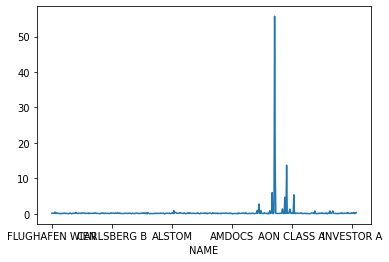

In [60]:
df_returns_annualized.plot()

OptionError: No such keys(s): 'mode.use_inf_as_null'

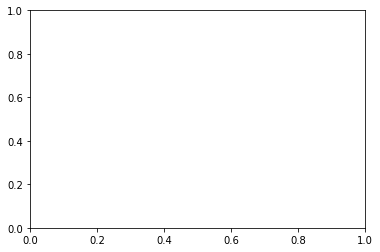

In [17]:
sns.histplot(df_returns_annualized)

In [18]:
deviations = df_returns_monthly - df_returns_monthly.mean()
squared_deviations = deviations**2
mean_squared_deviations = squared_deviations.mean()

df_volatility_monthly = np.sqrt(mean_squared_deviations)
df_volatility_monthly

NAME
FLUGHAFEN WIEN              0.084848
ERSTE GROUP BANK            0.120586
OMV                         0.102971
VERBUND                     0.092010
WIENERBERGER                0.111653
                              ...   
NIBE INDUSTRIER             0.098477
ELECTROLUX B                0.107010
ATLAS COPCO A               0.093084
MODERN TIMES GROUP MTG B    0.140888
BOLIDEN ORD SHS             0.197419
Length: 508, dtype: float64

In [19]:
df_volatility_annualized = df_volatility_monthly*(12**0.5)
df_volatility_annualized

NAME
FLUGHAFEN WIEN              0.293923
ERSTE GROUP BANK            0.417721
OMV                         0.356703
VERBUND                     0.318733
WIENERBERGER                0.386777
                              ...   
NIBE INDUSTRIER             0.341135
ELECTROLUX B                0.370693
ATLAS COPCO A               0.322453
MODERN TIMES GROUP MTG B    0.488051
BOLIDEN ORD SHS             0.683881
Length: 508, dtype: float64

<AxesSubplot:xlabel='NAME'>

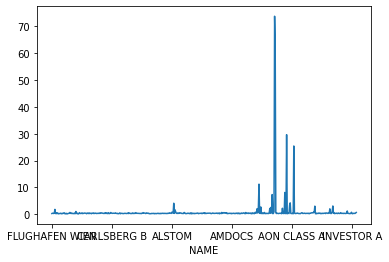

In [20]:
df_volatility_annualized.plot()

# Question 2

Report the following statistics for both portfolios: annualized average return, annualized volatility, Sharpe ratio, minimum return, and maximum return. Plot the time series of cumulated returns for both portfolios. (15 points)

### Equally weighted portfolio

In [21]:
#Creating a vector with equal weights for the 508 firms
n_columns = 508

#df_weight = pd.DataFrame([1/n_columns] * n_columns).T

weight = 1/508

weight

0.001968503937007874

In [25]:
#Equally weighted portfolio (average returns of all firms per each month)
portfolio_returns_EW = (df_returns_monthly*weight).sum(axis=1)
portfolio_returns_EW

2000-01-31 00:00:00    0.000000
2000-02-29 00:00:00    0.030608
2000-03-31 00:00:00    0.036612
2000-04-30 00:00:00   -0.034100
2000-05-31 00:00:00    0.010113
                         ...   
2022-08-31 00:00:00   -0.068045
2022-09-30 00:00:00   -0.119233
2022-10-31 00:00:00    0.099507
2022-11-30 00:00:00    0.107013
2022-12-31 00:00:00    0.011110
Length: 276, dtype: float64

In [40]:
portfolio_returns_EW.index = pd.to_datetime(portfolio_returns_EW.index)

# Filter DataFrame based on the condition
filtered_df = portfolio_returns_EW['2007-12-31':] 

In [42]:
EW_returns = filtered_df.pct_change()
EW_returns_avrg_ann = EW_returns.mean()*12
EW_returns_avrg_ann

16.45520016380349

In [63]:
portfolio_vol_EW = portfolio_returns_EW.std()*np.sqrt(12)
portfolio_vol_EW

0.332291816069465

### Value weighted portfolio

In [98]:
# Calculate weights for each month based on previous month's capitalization
total_cap_previous = df_capitalization_monthly_T.sum(axis=1)
weights = df_capitalization_monthly_T.div(total_cap_previous, axis=0).mean()

# Calculate the value-weighted portfolio returns
portfolio_returns_VW = (df_returns_monthly* weights).sum(axis=1)
portfolio_returns_VW

2000-01-31 00:00:00    0.000000
2000-02-29 00:00:00    0.037078
2000-03-31 00:00:00    0.079752
2000-04-30 00:00:00   -0.017788
2000-05-31 00:00:00    0.027040
                         ...   
2022-08-31 00:00:00   -0.055757
2022-09-30 00:00:00   -0.093462
2022-10-31 00:00:00    0.089919
2022-11-30 00:00:00    0.106490
2022-12-31 00:00:00    0.002098
Length: 276, dtype: float64

In [101]:
weights

NAME
FLUGHAFEN WIEN              0.000230
ERSTE GROUP BANK            0.001638
OMV                         0.001546
VERBUND                     0.000743
WIENERBERGER                0.000321
                              ...   
NIBE INDUSTRIER             0.000395
ELECTROLUX B                0.000950
ATLAS COPCO A               0.002328
MODERN TIMES GROUP MTG B    0.000272
BOLIDEN ORD SHS             0.000535
Length: 508, dtype: float64

In [102]:
portfolio_returns_VW.index = pd.to_datetime(portfolio_returns_VW.index)

# Filter DataFrame based on the condition
filtered_df = portfolio_returns_VW['2007-12-31':] 

In [114]:
VW_returns = filtered_df.pct_change()
VW_returns[VW_returns < 0] = 0
VW_returns_avrg_ann = VW_returns.mean()*12
VW_returns_avrg_ann

5.927302771740634

In [115]:
cov_m = df_returns_monthly.cov()

In [116]:
cov_m

NAME,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,VOESTALPINE,MAYR-MELNHOF KARTON,IMMOFINANZ,SOLVAY,...,FABEGE,KINNEVIK B,INVESTOR A,SWEDISH MATCH DEAD - DELIST.02/01/23,HEXAGON B,NIBE INDUSTRIER,ELECTROLUX B,ATLAS COPCO A,MODERN TIMES GROUP MTG B,BOLIDEN ORD SHS
NAME,,,,,,,,,,,,,,,,,,,,,
FLUGHAFEN WIEN,0.007225,0.005525,0.004224,0.003899,0.004274,0.003990,0.004127,0.002792,0.004952,0.003081,...,0.002918,0.003320,0.002734,0.001455,0.003202,0.002406,0.003234,0.002673,0.003719,0.002909
ERSTE GROUP BANK,0.005525,0.014594,0.006853,0.005705,0.007667,0.006629,0.006755,0.004043,0.007949,0.006576,...,0.004956,0.005386,0.004787,0.002837,0.006072,0.003920,0.005740,0.004600,0.006274,0.007245
OMV,0.004224,0.006853,0.010642,0.004360,0.004742,0.011475,0.005869,0.003248,0.006365,0.004617,...,0.003709,0.005853,0.003244,0.001964,0.004228,0.002882,0.004067,0.003606,0.004892,0.007136
VERBUND,0.003899,0.005705,0.004360,0.008497,0.004053,0.005595,0.004431,0.002679,0.004215,0.003249,...,0.003096,0.003898,0.002912,0.001633,0.003762,0.002501,0.002510,0.002486,0.004004,0.003391
WIENERBERGER,0.004274,0.007667,0.004742,0.004053,0.012512,0.006581,0.007012,0.003659,0.006901,0.005645,...,0.005667,0.006332,0.004615,0.001853,0.006480,0.005030,0.006299,0.005155,0.007194,0.005905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NIBE INDUSTRIER,0.002406,0.003920,0.002882,0.002501,0.005030,0.000550,0.004136,0.002226,0.004587,0.003383,...,0.004971,0.004695,0.003785,0.001753,0.005294,0.009733,0.004366,0.004151,0.005056,0.005643
ELECTROLUX B,0.003234,0.005740,0.004067,0.002510,0.006299,0.002793,0.005639,0.002718,0.005275,0.004161,...,0.004547,0.004635,0.004517,0.001666,0.006844,0.004366,0.011493,0.005951,0.006688,0.008072
ATLAS COPCO A,0.002673,0.004600,0.003606,0.002486,0.005155,0.004244,0.005714,0.002642,0.004705,0.003977,...,0.004652,0.006171,0.004854,0.001472,0.006487,0.004151,0.005951,0.008696,0.007083,0.008950


In [117]:
weights

NAME
FLUGHAFEN WIEN              0.000230
ERSTE GROUP BANK            0.001638
OMV                         0.001546
VERBUND                     0.000743
WIENERBERGER                0.000321
                              ...   
NIBE INDUSTRIER             0.000395
ELECTROLUX B                0.000950
ATLAS COPCO A               0.002328
MODERN TIMES GROUP MTG B    0.000272
BOLIDEN ORD SHS             0.000535
Length: 508, dtype: float64

In [118]:
def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

In [119]:
portfolio_vol_VW = portfolio_vol(weights, cov_m)

In [120]:
portfolio_vol_VW = portfolio_returns_VW.std()*np.sqrt(12)
portfolio_vol_VW

0.2030086470755982

# Question 3

### Get the dataset 

In [ ]:
#ESG
Env_index_path = r'C:\Users\giuli\Documents\SEF_Homework1\SEF\ESG_Scores\DS_EScore_Y.xlsx'  # Replace with your Excel file name
df_Env = pd.read_excel(Env_index_path)

#Country to region data
region_path = r'C:\Users\giuli\Documents\SEF_Homework1\SEF\CountriesToRegions.xlsx'  # Replace with your Excel file name
df_region = pd.read_excel(region_path)


#let's  keep only the EUR contries

df_region.drop(index=[0,1,2,3], inplace= True )

df_EUR = df_region[df_region['Unnamed: 2'] == 'EUR']

#Rename the column so we can merge later
df_EUR = df_EUR.rename(columns={'% AMER: Cnada + USA' : 'ISIN_First2'})

print(df_EUR)
print(df_Env)

#Now merged with the two dataset 
#First step we need to create a new column with only the 2 first caracters of the column ISIN

df_Env['ISIN_First2'] = df_Env['ISIN'].str[:2]
print(df_Env)


#Second step we merge the data set with the region, keeping only the one matching the EUR countries
df_Env_Y = pd.merge(df_EUR,  df_Env, on='ISIN_First2', how='inner')

columns_to_keep = [col for col in df_Env_Y.columns if not ('x1999' <= col <= 'x2006')]

df_Env_Y = df_Env_Y[columns_to_keep]

df_Env_Y.columns = df_Env_Y.columns.str.replace('x', '')

print(df_Env_Y)
df_Env_Y

   ISIN_First2       Unnamed: 1 Unnamed: 2
7           AT          AUSTRIA        EUR
11          BE          BELGIUM        EUR
19          CH      SWITZERLAND        EUR
26          DE          GERMANY        EUR
27          DK          DENMARK        EUR
30          ES            SPAIN        EUR
31          FI          FINLAND        EUR
32          FR          FRANCE         EUR
33          GB  UNITED KINGDOM         EUR
43          IE          IRELAND        EUR
44          IL          ISRAEL         EUR
48          IT            ITALY        EUR
71          NL      NETHERLANDS        EUR
72          NO          NORWAY         EUR
80          PT        PORTUGAL         EUR
87          SE          SWEDEN         EUR
              ISIN                           NAME  x1999  x2000  x2001  x2002  \
0     AN8068571086                   SCHLUMBERGER    NaN    NaN    NaN  53.65   
1     AT000000STR1                     STRABAG SE    NaN    NaN    NaN    NaN   
2     AT00000VIE62        

,ISIN_First2,Unnamed: 1,Unnamed: 2,ISIN,NAME,2007,2008,2009,2010,2011,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AT,AUSTRIA,EUR,AT000000STR1,STRABAG SE,3.81,22.87,30.90,44.29,58.66,...,50.09,48.69,55.55,56.98,58.49,64.61,62.49,60.42,58.09,56.89
1,AT,AUSTRIA,EUR,AT00000VIE62,FLUGHAFEN WIEN,1.31,23.14,31.84,28.27,31.09,...,27.17,34.81,51.84,47.48,78.01,76.99,71.53,75.00,78.49,NaN
2,AT,AUSTRIA,EUR,AT0000606306,RAIFFEISEN BANK INTL.,18.32,41.52,37.08,66.61,66.05,...,68.68,73.75,75.14,82.52,82.94,61.29,63.22,61.36,62.62,61.64
3,AT,AUSTRIA,EUR,AT0000652011,ERSTE GROUP BANK,54.81,61.22,74.29,70.81,84.47,...,83.81,79.57,81.98,83.86,87.20,80.89,81.18,79.44,76.58,76.91
4,AT,AUSTRIA,EUR,AT0000720008,TELEKOM AUSTRIA,37.76,77.76,85.48,78.31,75.08,...,71.34,73.61,73.82,62.69,63.56,63.59,64.30,64.79,59.94,59.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,SE,SWEDEN,EUR,SE0016589188,ELECTROLUX B,91.44,92.81,90.98,71.95,83.03,...,80.68,77.75,76.38,80.69,66.64,66.36,70.94,75.90,81.60,82.91
532,SE,SWEDEN,EUR,SE0017486889,ATLAS COPCO A,77.24,75.46,74.50,77.82,86.62,...,82.89,79.49,76.71,76.36,79.25,81.45,82.24,84.08,84.56,80.82
533,SE,SWEDEN,EUR,SE0018012494,MODERN TIMES GROUP MTG B,0.00,17.14,28.20,32.52,73.90,...,67.94,65.88,71.52,68.49,63.17,58.79,64.91,64.91,64.28,65.74
534,SE,SWEDEN,EUR,SE0018012635,WIHLBORGS FASTIGHETER,52.75,45.73,54.42,61.85,68.14,...,58.63,59.99,72.87,69.28,60.69,57.71,57.71,63.23,58.48,51.34


In [ ]:
df_Env_firms = df_Env_Y['ISIN'].unique.tolist()

df_Env_M = df_EUR_monthly_RI[df_EUR_monthly_RI['ISIN'].isin(df_Env_firms)]

df_Env_M

AttributeError: 'function' object has no attribute 'tolist'